# Exercise 3: The complex temporality of real world data

In this exercise we consider the complex temporality of real world data. An advantage of real world data compared to other sources of data is its rapid availability after collection. Clinical notes are for instance often available in a clinical data warehouse one day after their editions. Yet this strong advantage comes at a cost: the **heterogeneity of data temporalities**.

We consider hereafter a statistical design that considers only data collected in a timespan $[t_{start}, t_{end}]$ and we evaluate the impact of data temporality on the choice of $t_{start}$ and $t_{end}$. As underlined in the previous exercises, data that is available in a clinical data data warehouse has been collected in various clinical softwares. Each software may feature a specific temporality, leading to an important heterogeneity. Hereafter, we consider the two following characteristics of data temporality:
- **data timeliness** refers to the time needed to integrate data in the clinical data warehouse after the occurrence of the event of interest. If $t_{extract}$ refers to the date of data extraction from the clinical data warehouse for a study, and $\Delta t_{timeliness}$ refers to the duration separating events from the full availability of their related data in a clinical data warehouse, one should limit the timespan of a study to the period before $t_{end} = t_{extract} - \Delta t_{timeliness}$
- **software deployment** refers to the fact that data may be available in a medical unit only if its associated clinical software has been deployed and used in this medical unit at the date of interest. The heterogeneity due to the software deployment is not only a heterogeneity relatively to the categories of data, but also relatively to the medical units, as the deployment of a clinical software may be realized progressively in a hospital. If one knows for each medical unit $i$ and a data category $cat$ the date $t^{(0)}_{cat}(i)$ of the software deployment, one can restrict the study to medical units $i$ such that $t^{(0)}_{cat}(i)<t_{start}$. This restriction makes it possible to consider a stable source of data throughout the period of the study.

We illustrate now these challenges on our illustrative use case. As in exercise 1, we consider only structured data which timeliness parameters are known. We moreover assume that $t_{start}$ is set to the January 1st, 2022 by the investigator and that this date cannot be modified due to methodological issues.

We initialize the notebook by importing the following libraries:

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import datetime
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [3]:
import sys
sys.path.append("../")
from viz import plot_primary_kaplan, plot_secondary_kaplan

# 1. Data Exploration

A fake dataset that mimics data coming from a clinical information system is made available in the */data* folder of this exercise.
<br>For this study, data has been extracted from the Clinical Data Warehouse on December 1st, 2025.
<br>The same data than in exercice 1 is imported

## 1.1 Data extracted from the Clinical Data Warehouse

Open the following files using the `pandas.read_pickle()` function : 
  - *data/df_person.pkl* as `df_person`
  - *data/df_visit.pkl* as `df_visit`
  - *data/df_condition.pkl* as `df_cond`
  - *data/df_med.pkl* as `df_med`

In [4]:
# Patients
df_person = #TODO
# Visits
df_visit = #TODO
# Diagnosis (condition)
df_cond = #TODO
# Medication
df_med = #TODO

## 1.2 A priori knowledge on data timeliness

We moreover assume that we have an a priori knowledge of the timeliness parameter $\Delta t_{timeliness}$ of each data category:
- $\Delta t_{timeliness}^{(person)} = 1$ days
- $\Delta t_{timeliness}^{(visit)} = 5$ days 
- $\Delta t_{timeliness}^{(cond)} = 45$ days
- $\Delta t_{timeliness}^{(med)} = 5$ day


# 2. Exploration and pre-processing of the dataset

We consider that the data cleaning presented in the exercise 1 has already been realized on the dataset. We now focus on the temporality issue.

## 2.1 Adapting the study design to data timeliness

Let's first set the end value of the study's timespan, $t_{end}$.

**Reminder**: we assume data was extracted from the clinical data warehouse on t_{extract} = December 1, 2025.

We should consider a sufficiently long delay $\Delta t_{timeliness}$ between the extraction time and the end of the study in order to account for the timeliness of all the categories of data:

$\Delta t_{timeliness} = \max \big[\Delta t_{timeliness}^{(person)}, \Delta t_{timeliness}^{(visit)}, \Delta t_{timeliness}^{(cond)}, \Delta t_{timeliness}^{(med)} \big]= 45$ days.

We can consequently set the value of $t_{end}$ to $t_{extract} - \Delta t_{timeliness}$

In [5]:
t_max = #TODO

df_visit_fix = #TODO

## 2.2 Adapting the study design to the temporality of softwares' deployment

For the sake of simplicity, we consider hereafter that the clinical softwares used to collect patients' identities, visits administrative information and medical conditions have been deployed long before the beginning of our study $t_{start}$. We focus therefore on the correction of the variability induced by the progressive deployment of the software used to collect medication data. We moreover assume that this software has been deployed per hospital (*i.e.* there is one $t^{(0)}_{med}$ per hospital).

Let us first install the *eds-temporal-variability* library to benefit from its methods. This library has been developed to facilitate the handling of the software deployment temporality when considering data of the Greater Paris University Hospitals' Clinical Data Warehouse. Don't hesitate to read the library's documentation.

**Creation of a probe related to medicaton data**

As explained in the library's documentation, one may first define a probe per hospital to measure the variation of data availability in the clinical data warehouse.

In [6]:
from edsteva.etl.probes.base import BaseProbe 

class VisitWithMed(BaseProbe):
    @classmethod
    def _from_spark(cls, sql):
        #TODO
        return df_probe

visit_with_med = VisitWithMed.from_spark(sql=None)
visit_with_med.head()

,care_site_level,care_site_id,stay_type,probe_subtype,date,n_visit,rho
0,hospital,Centre F.Sinoussi,all,all,2019-12-01,198,0.580808
1,hospital,Centre F.Sinoussi,all,all,2020-01-01,220,0.590909
2,hospital,Centre F.Sinoussi,all,all,2020-02-01,200,0.545000
3,hospital,Centre F.Sinoussi,all,all,2020-03-01,236,0.563559
4,hospital,Centre F.Sinoussi,all,all,2020-04-01,208,0.615385


**Estimation of $t^{(0)}_{med}$ for each hospital**

We consider now a simple fitting procedure, available in the *eds-temporal-variability* library to estimate $t^{(0)}_{med}$ for each hospital using the previously defined probe.

In [7]:
from edsteva.etl.estimators.general import generic_8th_decile_v1
from edsteva.etl.estimate import Estimate

estimate = Estimate.from_probe(#TODO)
estimate.head()

,care_site_id,estimate_id,concept_name,concept_value
8,Centre F.Sinoussi,0,rho_0,0.623937
9,Clinique L.Pasteur,0,rho_0,0.690542
10,GHU A.Fleming,0,rho_0,0.69412
11,Hopital M.Bres,0,rho_0,0.688617
16,Centre F.Sinoussi,0,t0,2019-12-01 00:00:00


We now visualize the estimates of the deployment dates for each hospital.

In [8]:
from edsteva.viz import plot_probe
from edsteva.utils import get_estimate_id

def get_viz_df():
    dict_struct = {i: name for i, name in enumerate(visit_with_med.care_site_id.unique())}
    df_struct_inverse = {name: i for i, name in dict_struct.items()}
    df_probe = visit_with_med.copy()
    df_probe['care_site_id'] = df_probe['care_site_id'].apply(lambda x: df_struct_inverse[x])
    df_result = estimate.copy()
    df_result['care_site_id'] = df_result['care_site_id'].apply(lambda x: df_struct_inverse[x]).astype(str)

    df_struct = (
        pd.DataFrame.from_dict(dict_struct, 'index')
        .reset_index()
        .rename(columns={'index': 'care_site_id', 0: 'concept_value'})
        .assign(concept_name=lambda pp: "lib")
    )
    return df_probe, df_struct, df_result

df_probe, df_struct, df_result = #TODO
estimate_id = get_estimate_id(#TODO)
plot_probe(#TODO)

alt.LayerChart(...)

For each care site, we can see a step-shaped data availability curve. The step is centered on a date that is probably the date of the software's deployment. Yet, data is also available before this date... this may be due for instance to the fact that some data collected in previous clinical softwares is imported in the new software when it is deployed. This imported data is of lower quality than data natively collected in the new software because old data is filtered before import using rules that are usually not available to researchers, thus inducing potential statistical biases.

**Filter data in order to correct for the deployment bias**

We now filter data to keep only data originating from hospitals where the medication software was deployed before the beginning date of our study. 

In [9]:
t_start = #TODO

In [10]:
list_taboo_hospital = []
for _, row in estimate.query('concept_name=="t0"').iterrows():
    if row['concept_value'] > t_start:
        list_taboo_hospital.append(row['care_site_id'])
print('Hospitals which data is discarded: {}'.format(list_taboo_hospital))
df_visit_fix = df_visit.query('care_site_id not in @list_taboo_hospital')

Hospitals which data is discarded: ['Hopital M.Bres']


We moreover filter visits that begin before $t_{start}$.

In [11]:
df_visit_fix = #TODO

# 3. Statistical analysis

Now that we have pre-processed raw data to correct flawed or missing values and to define research-relevant variables, we can conduct the statistical analysis. We plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests. 

**Primary objective: are the drugs efficient on the total population?**

**Remark**: the Kaplan-Meier plot functions admit as parameter the end date of the study `t_end`.

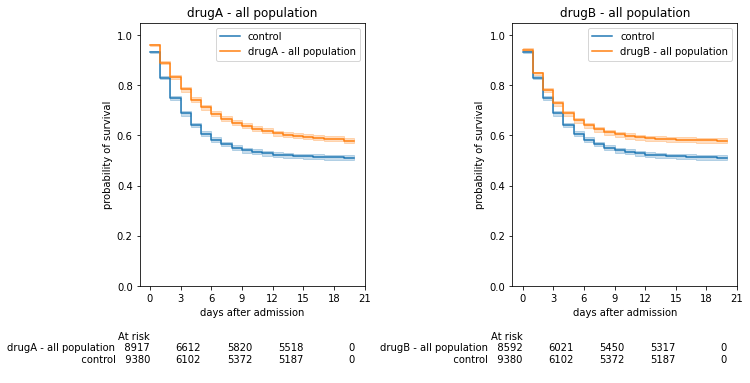

In [12]:
plot_primary_kaplan(#TODO)

The results are coherent with exercise 1.

**Secondary objective: sub-population analysis**

To reach our secondary objective, we now conduct the same statistical analysis on sub-populations that correspond to different sexes and ages to obtain a better insight on drugs efficiencies.

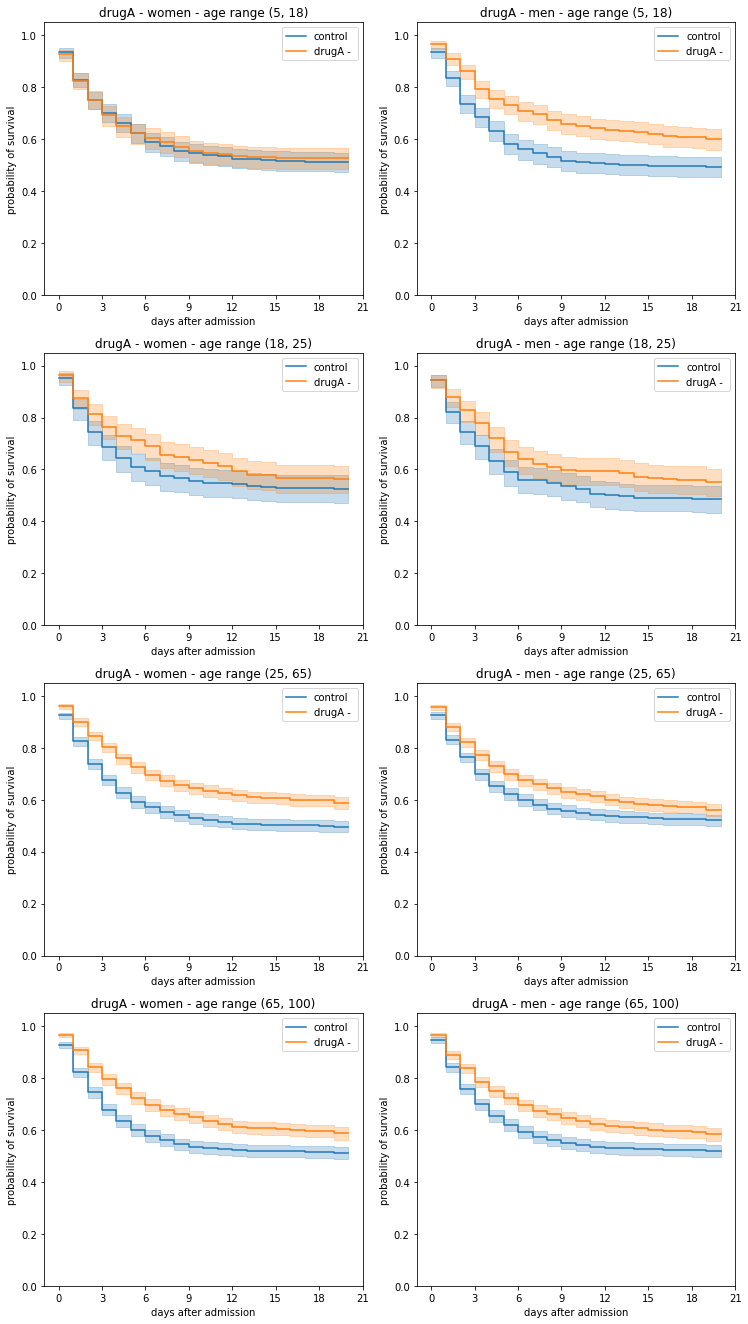

In [13]:
plot_secondary_kaplan(#TODO)

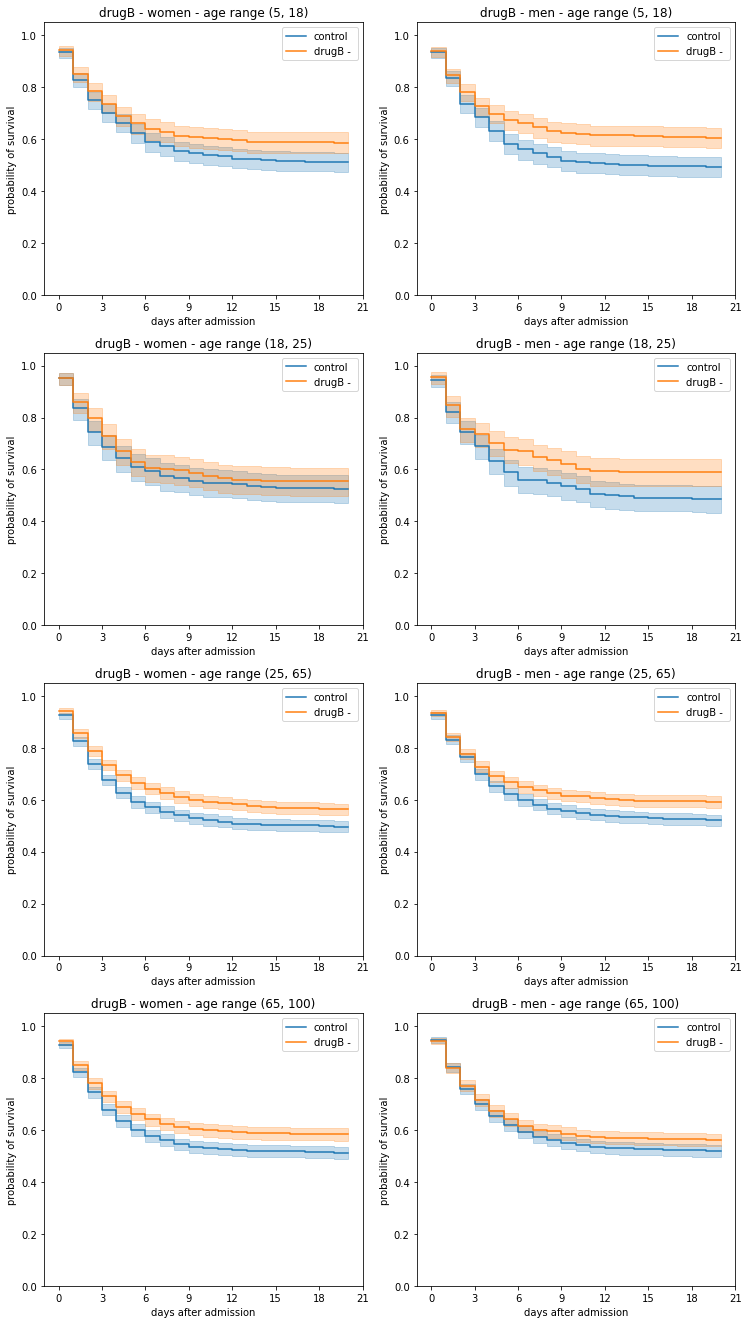

In [17]:
plot_secondary_kaplan(#TODO)

In this exercise we have introduced some difficulties related to handling the temporality of real world data. Using a simple example, we have shown how data temporality may impact the study design and how temporality parameters may be automatically computed using ad-hoc scientific libraries.

In a real clinical data warehouse, this issue is much more complex due to the strong heterogeneity of the clinical information system. Better understanding the dynamics of the clinical information system appears necessary to conduct some studies on real world data : the expertise of the IT department may be leveraged therefore.

# 4. Takeaways

- An important challenge regarding the analysis of real world data comes from the its **temporality**.
- Data **timeliness** refers to the latency of data integration. It may be due to various effects all over the data collection and curation workflows.
- Moreover the constant **evolution of the clinical information system** (deployments of new softwares, etc.) leads to an heterogeneous availability in time and space of data collected in a hospital. It therefore appears necessary to correct this **software deployment bias** in the study's design.

# 5. References

- Weiskopf, N. G., et C. Weng. « Methods and Dimensions of Electronic Health Record Data Quality Assessment: Enabling Reuse for Clinical Research ». Journal of the American Medical Informatics Association 20, nᵒ 1 (1 janvier 2013): 144‑51. https://doi.org/10.1136/amiajnl-2011-000681.
- Finlayson, Samuel G., Adarsh Subbaswamy, Karandeep Singh, John Bowers, Annabel Kupke, Jonathan Zittrain, Isaac S. Kohane, et Suchi Saria. « The Clinician and Dataset Shift in Artificial Intelligence ». New England Journal of Medicine 385, nᵒ 3 (15 juillet 2021): 283‑86. https://doi.org/10.1056/NEJMc2104626.
- Sáez, Carlos, Alba Gutiérrez-Sacristán, Isaac Kohane, Juan M García-Gómez, et Paul Avillach. « EHRtemporalVariability: Delineating Temporal Data-Set Shifts in Electronic Health Records ». GigaScience 9, nᵒ 8 (1 août 2020): giaa079. https://doi.org/10.1093/gigascience/giaa079.
